In [76]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver
from nanoepitools.math import llr_to_p, p_to_llr
from benchmark_pycometh.config import module_config

In [72]:
def estimate_beta_dist(x):
    mean = np.mean(x)
    var = np.var(x)
    alpha = ((1-mean) / var - 1/mean) *  mean**2
    beta = alpha * (1/mean - 1)
    return alpha, beta

In [47]:
pa = PlotArchiver("simulation", config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})

Fasta(module_config.reference)

Fasta("/home/r933r/data/resource/human/hg38/Ensembl_101/Homo_sapiens.GRCh38.dna.primary_assembly.fa")

In [7]:
mf = MetH5File(module_config.meth5_template_file.format(sample="HG002"), "r")

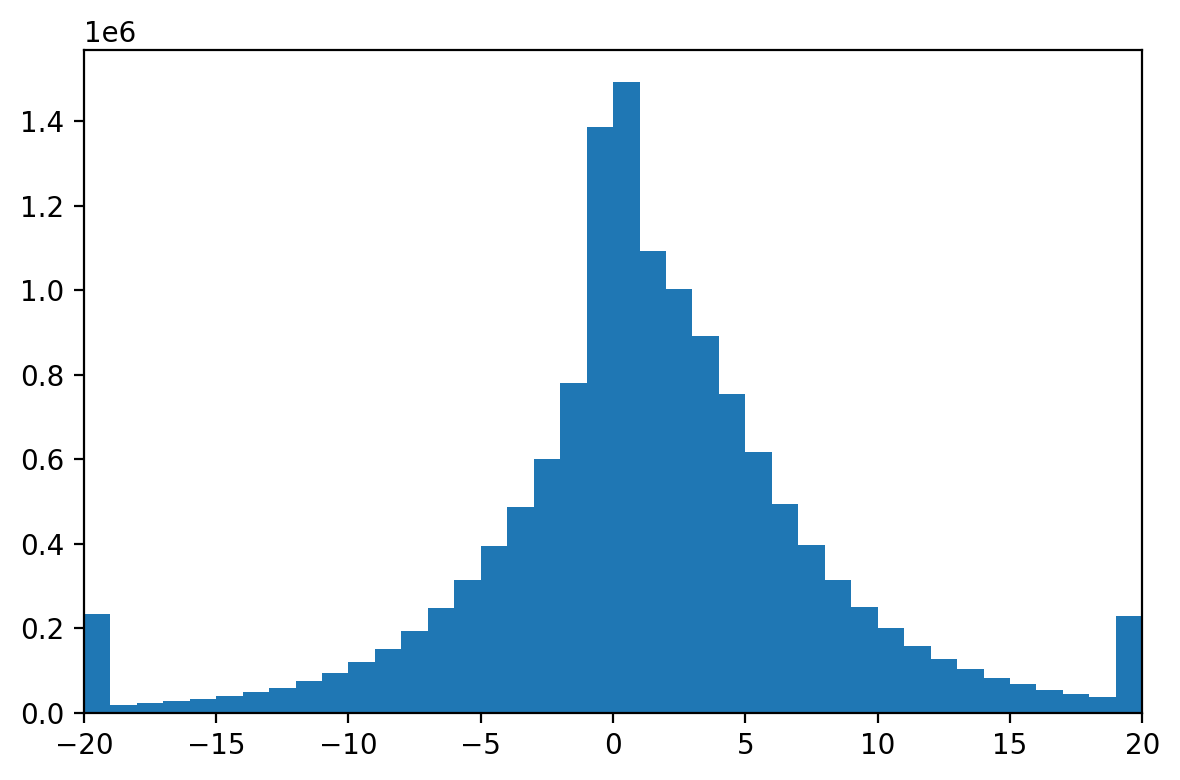

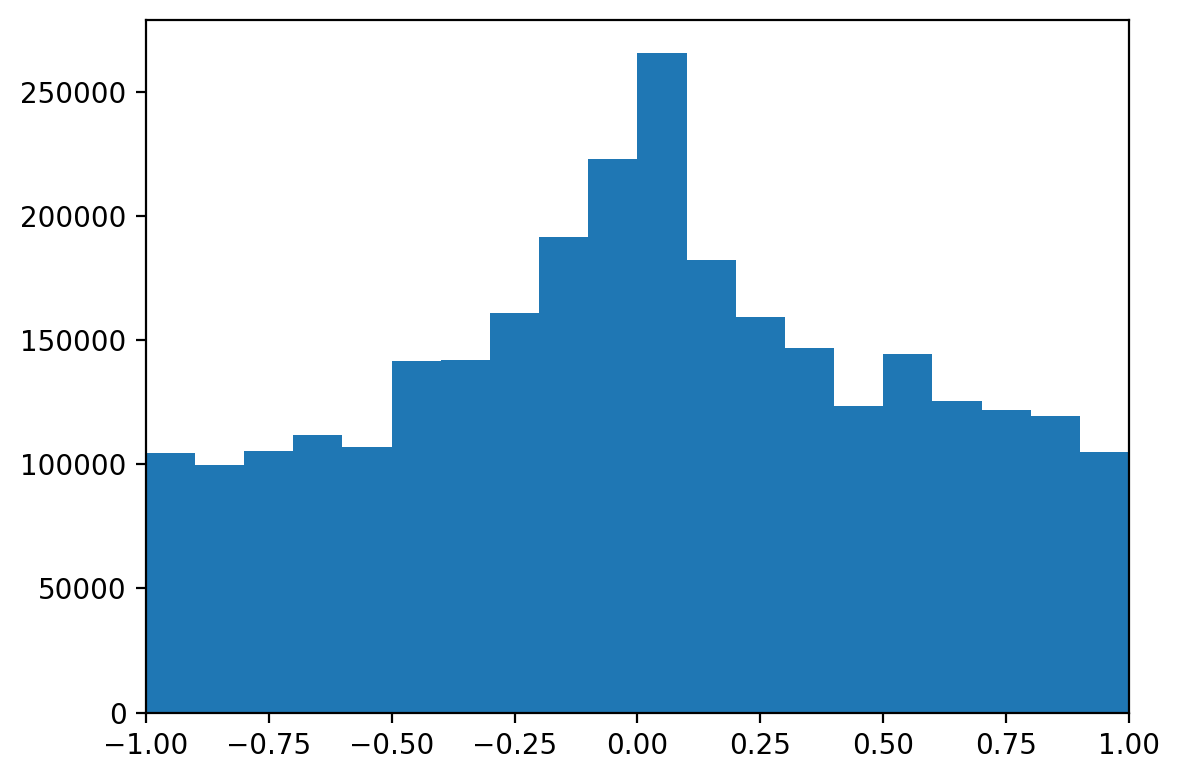

In [81]:
llrs = mf["21"].get_all_values().get_llrs()

pa.figure()
plt.hist(np.clip(llrs, -20, 20), bins=40)
plt.xlim(-20,20)
plt.show()

pa.figure()
plt.hist(np.clip(llrs, -20, 20), bins=400)
plt.xlim(-1,1)
plt.show()


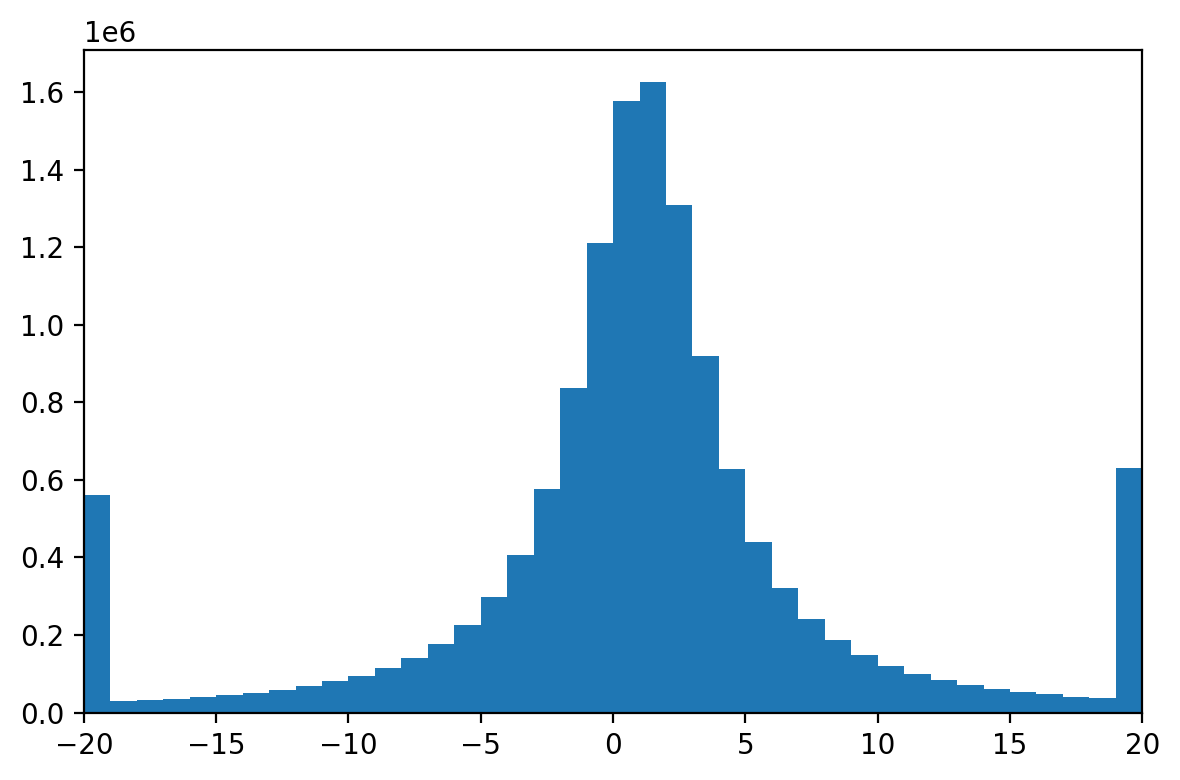

In [95]:
ts = np.random.standard_t(1, len(llrs))*2.6 + np.mean(llrs)

pa.figure()
plt.hist(np.clip(ts, -20, 20), bins=40)
plt.xlim(-20,20)
plt.show()

/home/r933r/code/nanoepitools/nanoepitools/math.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-llr) * (1 / prior - 1))


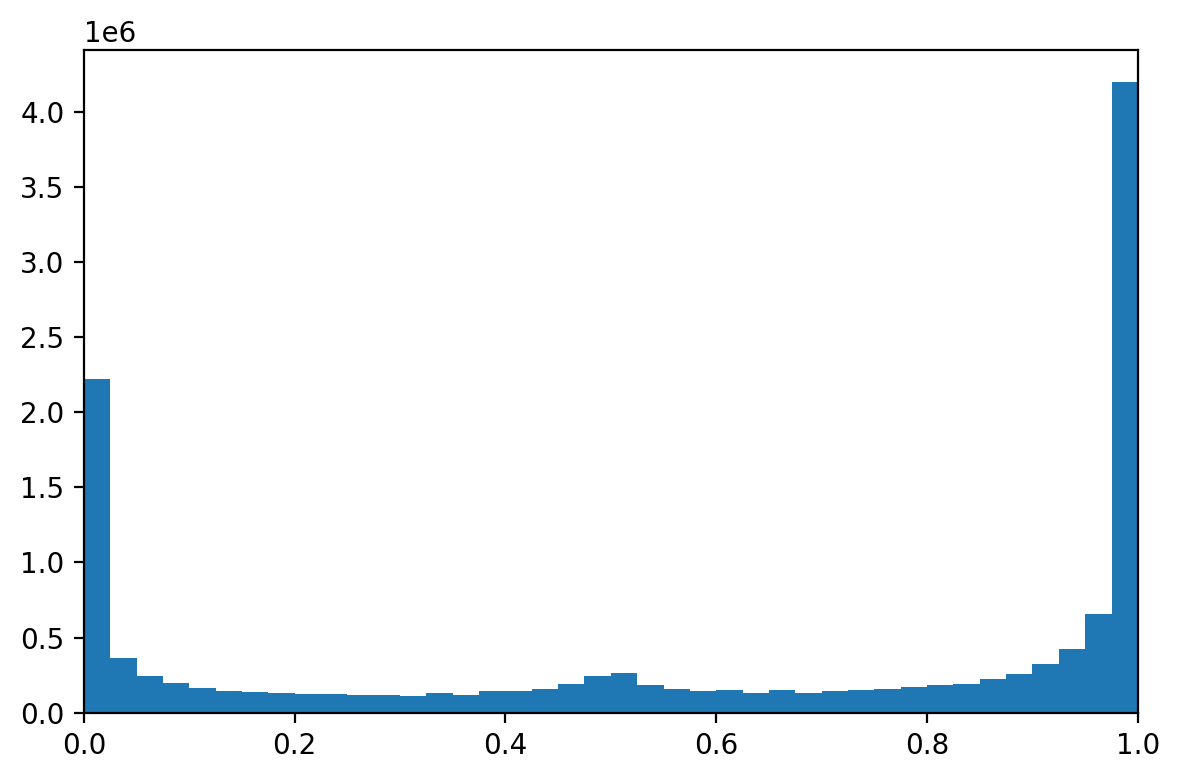

In [131]:
ps = llr_to_p(llrs)

pa.figure()
plt.hist(ps, bins=40)
plt.xlim(0,1)
plt.show()

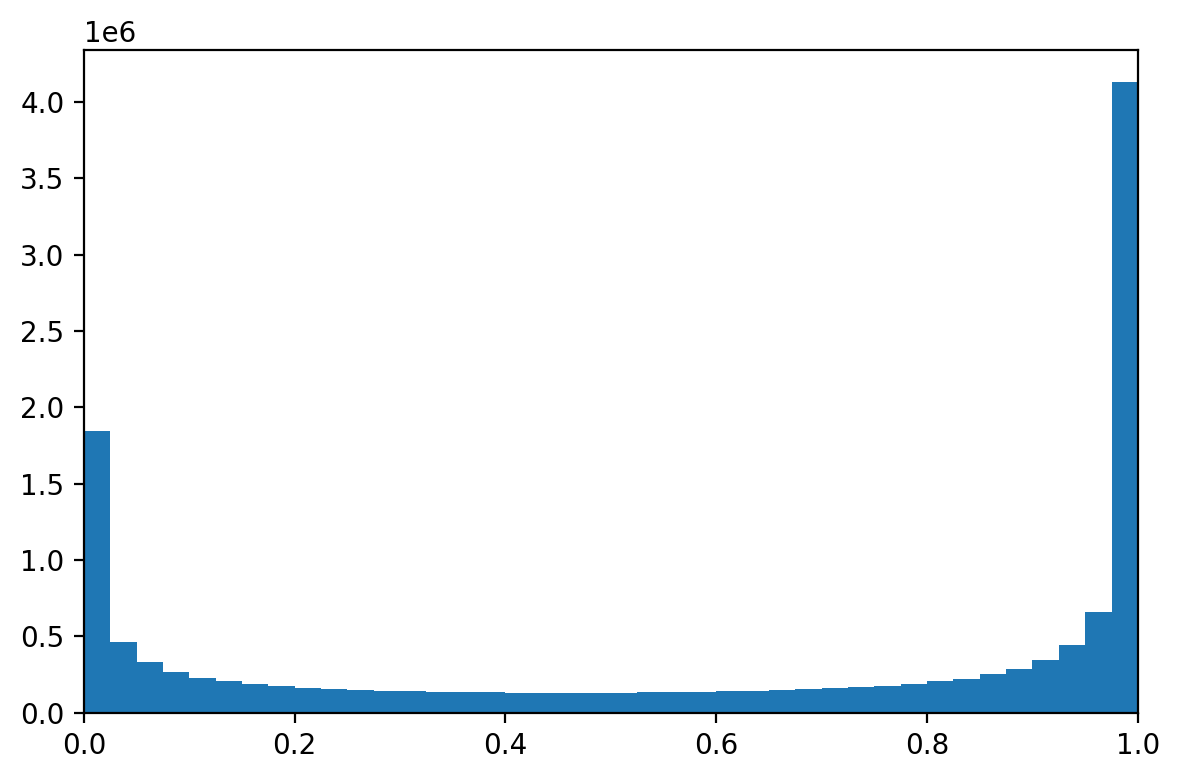

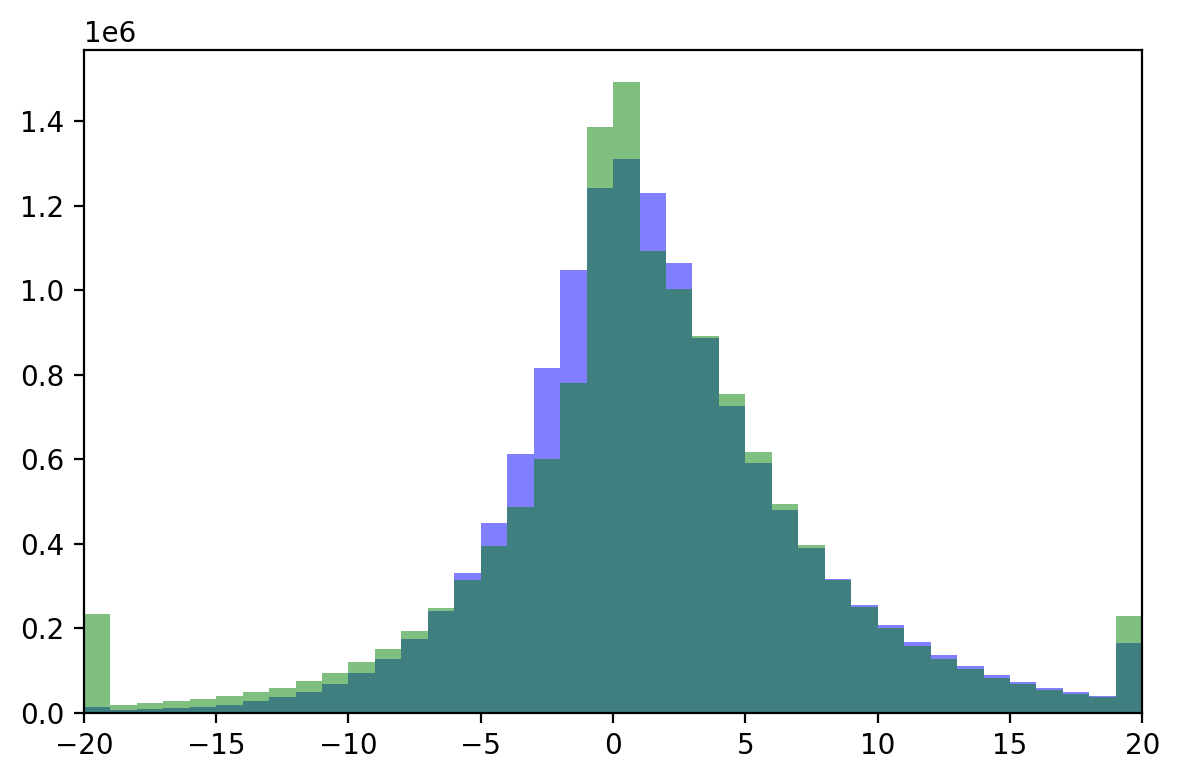

In [98]:
s = np.random.beta(*estimate_beta_dist(ps), len(ps))
pa.figure()
plt.hist(s, bins=40)
plt.xlim(0,1)
plt.show()

pa.figure()
plt.hist(np.clip(p_to_llr(s), -20, 20), bins=40, alpha = 0.5, color="blue")
plt.hist(np.clip(llrs, -20, 20), bins=40, alpha = 0.5, color="green")
plt.xlim(-20,20)
plt.show()

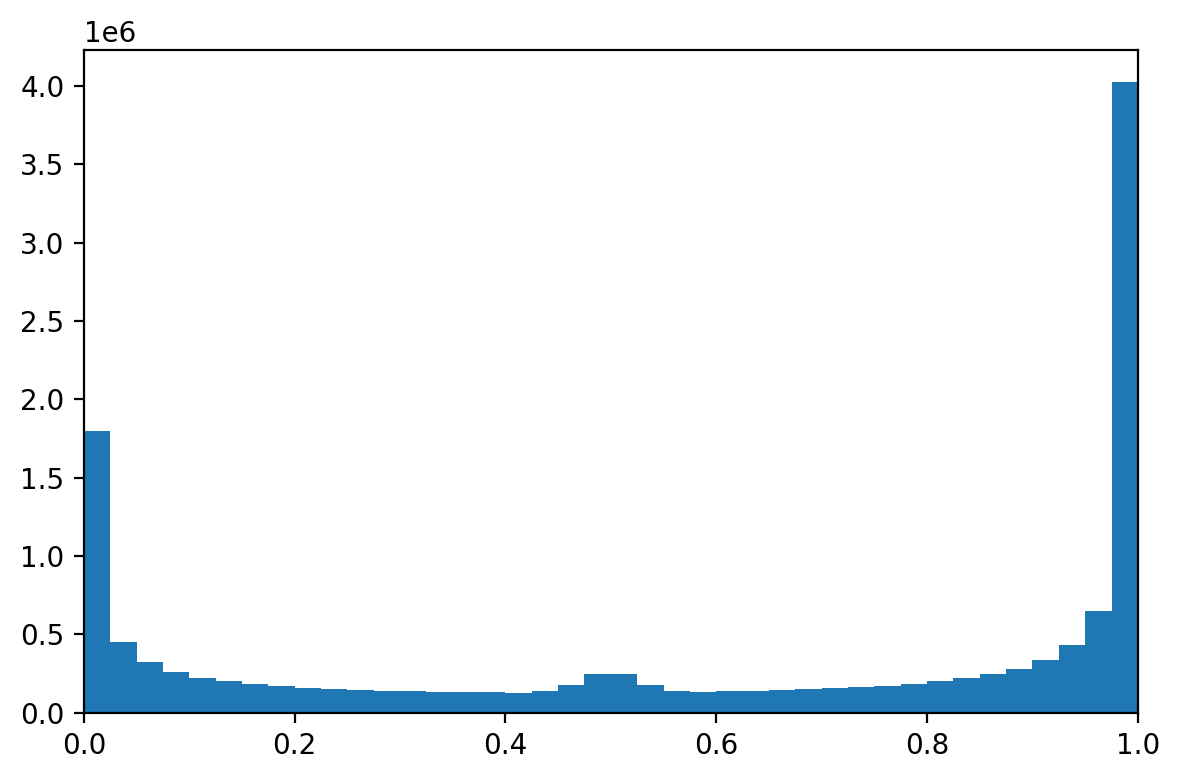

In [133]:
def draw_from_mixed_distribution(draw_funs, p, num):
    ret = np.zeros(num)
    choices = list(range(len(p)))
    idx = np.random.choice(choices, num, p=p)
    for i in choices:
        ret[idx == i] = draw_funs[i]((idx==i).sum())
    return ret

s = draw_from_mixed_distribution([
    lambda num: np.random.beta(*estimate_beta_dist(ps), num),
    lambda num: np.random.normal(0.5, 0.025, num)],
    p=[0.975,0.025], num=len(llrs))

pa.figure()
plt.hist(s, bins=40)
plt.xlim(0,1)
plt.show()

In [218]:
from pomegranate import *
class MyBetaDistribution(BetaDistribution):
    d=1

    def fit(self, X):
        super().fit(log_probability(X>0.5))

    def log_probability(self, X):
        return super().log_probability(X>0.5)



model = GeneralMixtureModel([NormalDistribution(0.5, 0.025), MyBetaDistribution( *estimate_beta_dist(ps))], weights=[0.025, 0.975])

In [219]:
model.fit(np.clip(ps,0.01, 0.99))

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                0.49957827342221744,
                0.02569747522026888
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "BetaDistribution",
            "parameters" : [
                0.0,
                13368216.4719915
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.025701909112939108,
        0.974298090887061
    ]
}

In [164]:
s = model.sample(len(llrs))
pa.figure()
plt.hist(s, bins=40)
plt.xlim(0,1)
plt.show()

ValueError: a <= 0

In [186]:
test = scipy.stats.beta.pdf(np.clip(ps, 1e-10, 1-1e-10), *estimate_beta_dist(ps))

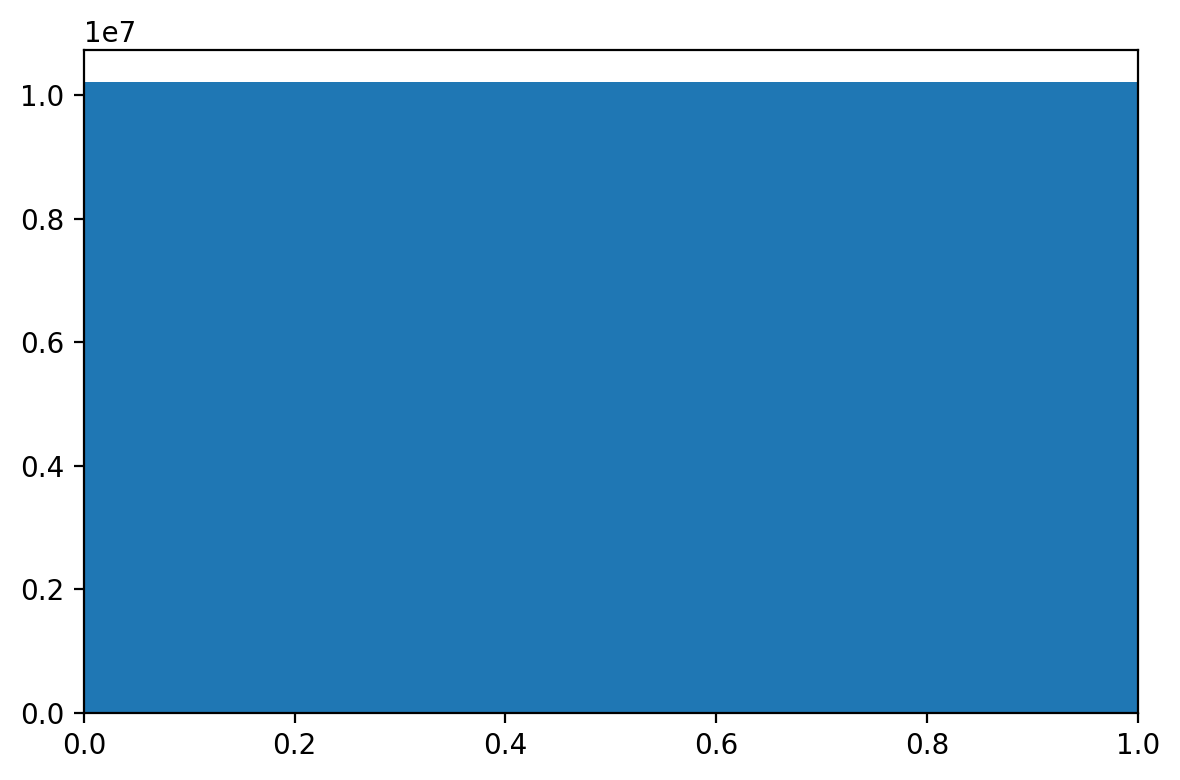

In [217]:
model = BetaDistribution(*estimate_beta_dist(ps))
s = model.sample(len(llrs))
model.fit(s)
s = model.sample(len(llrs))
pa.figure()
plt.hist(s, bins=40)
plt.xlim(0,1)
plt.show()

In [216]:
model

{
    "class" : "Distribution",
    "name" : "BetaDistribution",
    "parameters" : [
        3655.0,
        13717214.0
    ],
    "frozen" : false
}